# Labor del péndulo 
Hecho por: Daniela Gómez Aguilar y Santiago Hurtado Valencia

## Planteamiento del problema
El objetivo de la labor es mostrar las habilidades del grupo para modelar y analizar el problema propuesto por los docentes de la materia, este es el comportamiento de un péndulo simple no lineal, para ello se debe de realizar un experimento, en nuestro caso se usó un hilo de 50cm, con estos datos la idea es ajustar parametros para una regresión lineal y realizar simulaciones para poder comparar los datos experimentales con la regresión y simulaciones.

In [1]:
#Librerias
import pandas as pd #Librería para leer archivos como .xlsx, .csv, .mat, entre otros
import numpy as np #Librería para usar matematica dentro del programa
import matplotlib.pyplot as plt #Librería para graficar datos
from scipy.optimize import curve_fit #Librería para hacer una regresión
from scipy.integrate import solve_ivp #Librería para resolver ecuaciones diferenciales por métodos numéricos

## Fórmulas que se usaron para la creación de las clases usadas en el programa:

  Ecuación del método de Euler para una sola ecuación de una sola variable:
  
  $$u_{n+1} = u_n + \Delta tf(t_n,u_n)$$
  
  Estas ecuaciones se usarán a modo de serie de ecuaciones para poder modelar el péndulo por el método de Euler: 
  $$ \frac{d\theta}{dt} = \omega $$ 
  
  Esta es la primera derivada de la función del péndulo 
  $$ \frac{d\omega}{dt} = -\frac{g}{L}\sin(\theta) $$ 
  o 
  $$ \ddot{\theta} = -\frac{g}{L}\sin(\theta) $$
  
  Esta es la segunda derivada de la función del péndulo 
  
  La siguiente ecuación es para visualizar cómo queda el método de Euler para el uso de vectores dentro del programa:
  $$u_{k+1} = u_k + \Delta tf(u_k,t_k)$$ 
  
  Cada uno de los componentes son vectores

In [2]:
# Funciones usadas dentro del programa
def ecuacion(t, theta_m, omega_n, phi):
    t = t
    omega_n = np.degrees(omega_n)
    return theta_m * np.sin(np.radians(omega_n * t + phi)) #Ecuacion para la solución aproximada (modelo lineal)

def ecuacion_diferencial(t, y):
    theta, omega = y
    dtheta_dt = omega
    domega_dt = -(g / l) * np.sin(theta)
    return [dtheta_dt, domega_dt] #Ecuacion para un modelo no lineal mediante un método numérico

#Programación de la clase a usar dentro del programa sacada del libro "Solving Ordinary Differential Equations in Python" de Joakim Sundnes,
#en este caso usando el método de Euler, con respecto de problemas de valores iniciales. Como aclaración una clase se entiende que
#es una estructura de programación que permite definir un conjunto de métodos (función perteneciente a la clase) y atributos que describen un objeto o entidad
#Al ser en este caso un problema de doble derivada, es decir, una ecuación diferencial de segundo orden podemos desglozar la misma en dos ecuaciones
#la primera es la derivada del angulo (theta) con respecto al tiempo siendo esta igual a la frecuencia angular o velocidad angular (omega) y otra ecuación que es la
#segunda derivada, donde se deriva la velocidad angular (omega) sobre el tiempo que es igual a la razón negativa de la gravedad frente a la longitud de la cuerda del
#péndulo por el seno del angulo (theta)

class Metodo_Euler:
  def __init__(self, f):
      self.f = lambda t, u: np.asarray(f(t, u), float) #Constructor que toma un solo argumento para el lado derecho de la función f y se almacena como atributo, entiendase atributo como
      #variable que se define dentro de una clase, la cual almacena datos que pertenecen a un objeto de esa clase

  #En este caso como el problema requiere más de una ecuación y se usa como una serie de ecuaciones diferenciales, para resolver estas se debe de crear vectores para guardar cada una
  #de las soluciones en cada punto distinto
  def set_initial_condition(self, u0): #Se toma una condición inicial como argumento y se almacena
    if np.isscalar(u0): # Ecuación Diferencial Ordinaria (EDO) escalar
        self.neq = 1 # Número de ecuaciones usadas
        u0 = float(u0)
    else: # Sistema de EDOs
        self.neq = len(u0) # Número de ecuaciones usadas
        u0 = np.asarray(u0)
    self.u0 = u0

  def solve(self, t_span, N): #Función que toma el intervalo de tiempo (Periodo) y el número de pasos a usar como argumentos, además de usar un método numérico general (método de Euler)
  # por medio de un ciclo for para resolver la EDO y devolver la solución
      """Compute solution for
      t_span[0] <= t <= t_span[1],
      using N steps."""
      t0, T = t_span
      self.dt = (T - t0) / N
      self.t = np.zeros(N + 1)

      if self.neq == 1:
          self.u = np.zeros(N + 1)
      else:
          self.u = np.zeros((N + 1, self.neq))

      msg = "Please set initial condition before calling solve" #Esto nos mostrará cuál es el error que hicimos, en este caso el de no definir
      #las variables iniciales a usar dentro de la solución
      assert hasattr(self, "u0"), msg

      self.t[0] = t0
      self.u[0] = self.u0

      #Ciclo for para resolver el método numérico (método de Euler)
      for n in range(N):
          self.n = n
          self.t[n + 1] = self.t[n] + self.dt
          self.u[n + 1] = self.advance()
      return self.t, self.u

  def advance(self): #Función del método de Euler generalizada para cualquier EDO
      """Advance the solution one time step."""
      u, dt, f, n, t = self.u, self.dt, self.f, self.n, self.t
      return u[n] + dt * f(t[n], u[n])

#Clase creada solo para tener las fórmulas de la serie para la resolución del problema del péndulo
class Pendulo:
  #Datos iniciales que se usarán en la fórmula
  def __init__(self, L, g=9.807):
    self.L = L
    self.g = g
  #Método de la clase llamado call para usar la clase como una función dentro del programa
  def __call__(self, t, u):
    theta, omega = u
    dtheta = omega #Primera derivada
    domega = -self.g / self.L * np.sin(theta) #Segunda derivada
    return [dtheta, domega]

# Solución con un grado de inicio menor a 10°

In [3]:
#Lectura del archivo
df=pd.read_excel("datos-10g.xlsx")
#Datos que se usarán globalmente
l = 0.5  # Longitud usada de la cuerda del experimento
g = 9.807  # Gravedad de la tierra(mts/s2)
T = 1.499  #Periodo o ciclo que tiene el movimiento

In [4]:
df=pd.DataFrame(df)
tiempo = df["t"].to_numpy() #Datos del tiempo que pasan de un dataframe a un array numpy
angulo = df["a"].to_numpy() #Datos de los ángulos que pasan de un dataframe a un array numpy
angulo = angulo[103:192]
tiempo = tiempo[103:192]-1.733
print('El ángulo inicial que se va a usar para evaluar las simulaciones y regresión es: ', max(angulo))
theta_0_deg = max(angulo) #Este es el ángulo inicial que vamos a tomar y que se mostró anteriormente
theta_0 = np.deg2rad(theta_0_deg)

El ángulo inicial que se va a usar para evaluar las simulaciones y regresión es:  4.58458185195923


In [5]:
t_eval = np.linspace(0, T, len(tiempo)) #array de tiempo
popt, pcov = curve_fit(ecuacion, t_eval, np.interp(t_eval, tiempo, angulo), p0=[max(angulo), 2 * np.pi / T, 0]) #datos que se van a cambiar para tener una regresión
theta_m_opt, omega_n_opt, phi_opt = popt
print(f"Frecuencia angular natural ajustada: {omega_n_opt} grados/s") #Con esta frecuencia angular se va a hacer la regresión de la ecuación

Frecuencia angular natural ajustada: 3.5463734752358094 grados/s


In [6]:
problema = Pendulo(L=0.5) #Uso de la clase para poder tener la serie de ecuaciones diferenciales
solver = Metodo_Euler(problema) #uso de la clase para resolver la serie de ecuaciones por medio del método de Euler
solver.set_initial_condition([(max(angulo)*(np.pi/180)), 0]) #Datos iniciales que se usan dentro del método
N = 225 #Número de pasos usados en este programa
t, u = solver.solve(t_span=(0, T), N=N) #Solución de la EDO

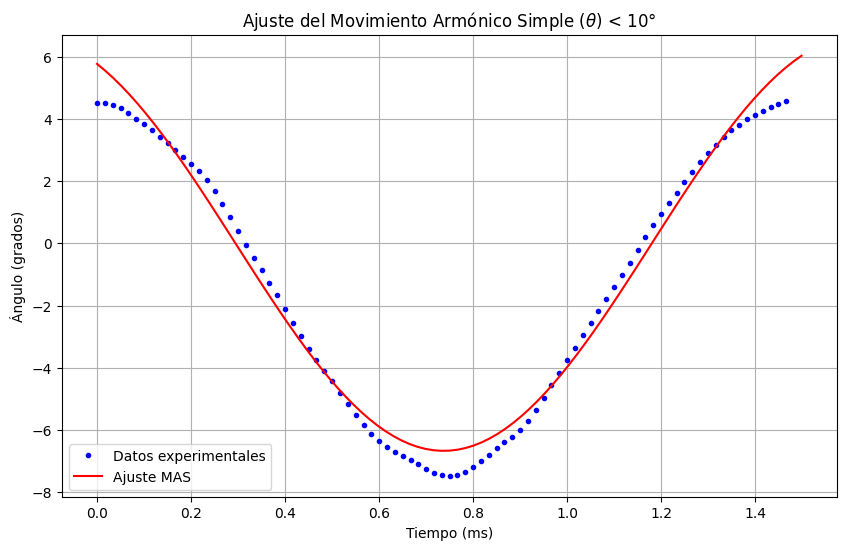

In [7]:
# Gráfica de ajuste MAS
plt.figure(figsize=(10, 6))
plt.plot(tiempo, angulo, 'b.', label='Datos experimentales')
plt.plot(t_eval, ecuacion(t_eval, *popt), 'r-', label='Ajuste MAS')
plt.title(r'Ajuste del Movimiento Armónico Simple ($\theta$) < 10°')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Ángulo (grados)')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
sol = solve_ivp(ecuacion_diferencial, [t_eval[0], t_eval[-1]], [theta_0,0], t_eval=t_eval) #Solución de la EDO por medio de SciPy
sol_y_deg = np.rad2deg(sol.y[0])

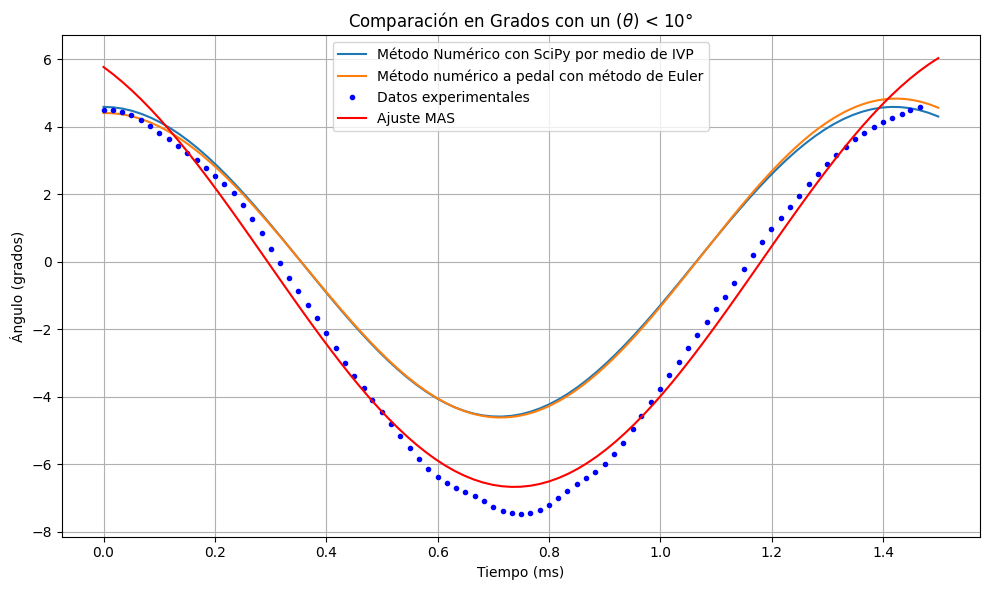

In [9]:
# Gráfica de comparación
plt.figure(figsize=(10, 6))
plt.plot(sol.t , sol_y_deg, label='Método Numérico con SciPy por medio de IVP')
plt.plot(t, u[:, 0]*55, label=r'Método numérico a pedal con método de Euler')
plt.plot(tiempo, angulo, 'b.', label='Datos experimentales')
plt.plot(t_eval, ecuacion(t_eval, *popt), 'r-', label='Ajuste MAS')
plt.title(r'Comparación en Grados con un ($\theta$) < 10°')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Ángulo (grados)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusiones para un ángulo menor de 10°
Dentro de esta gráfica se puede denotar de manera muy rápida como es que los datos experimentales no se tomaron de manera perfecta, habiendo datos que se mueven mucho, por ello al hacer la regresión lineal vemos como la misma no encaja casi perfectamente dentro de los datos experimentales como debería de hacerlo ya que es hecha con los datos experimentales y en base a ellos. Por otro lado visualizamos como las dos simulaciones hechas en este caso por un método de Euler a pedal y con SciPy (solucionador IVP) al seguir los datos de condición inicial vemos qué tan mal están los datos con respecto a una situación ideal. Además de visualizar como es que una simulación difiere de la otra.

# Solución con un grado de inicio mayor a 40°

In [10]:
#Lectura del archivo
df1=pd.read_excel("datos+45.xlsx")
#Datos que se usarán globalmente
l = 0.5  # Longitud (mts)
g = 9.807  # Gravedad (mts/s2)
T = 1.515 #Periodo o ciclo que tiene el movimiento

In [11]:
df1=pd.DataFrame(df1)
tiempo1 = df1["t"].to_numpy() #Datos del tiempo que pasan de un dataframe a un array numpy
angulo1 = df1["a"].to_numpy() #Datos de los ángulos que pasan de un dataframe a un array numpy
angulo = angulo1[68:159]
tiempo = tiempo1[68:159]-1.133
print('El ángulo inicial que se va a usar para evaluar las simulaciones y regresión es: ', max(angulo))
theta_0_deg = max(angulo) #Este es el ángulo inicial que vamos a tomar y que se mostró anteriormente
theta_0 = np.deg2rad(theta_0_deg)

El ángulo inicial que se va a usar para evaluar las simulaciones y regresión es:  45.1960678100586


In [12]:
t_eval = np.linspace(0, T, len(tiempo)) #
popt, pcov = curve_fit(ecuacion, t_eval, np.interp(t_eval, tiempo, angulo), p0=[max(angulo), 2 * np.pi / T, 0]) #datos que se van a cambiar para tener una regresión
theta_m_opt, omega_n_opt, phi_opt = popt
print(f"Frecuencia angular natural ajustada: {omega_n_opt} grados/s") #Con esta frecuencia angular se va a hacer la regresión de la ecuación

Frecuencia angular natural ajustada: 4.170089860436124 grados/s


In [13]:
problem = Pendulo(L=0.5) #Uso de la clase para poder tener la serie de ecuaciones diferenciales
solver = Metodo_Euler(problem) #uso de la clase para resolver la serie de ecuaciones por medio del método de Euler
solver.set_initial_condition([(max(angulo)*(np.pi/180)), 0]) #Datos iniciales que se usan dentro del método
N = 225 #Número de pasos usados en este programa
t, u = solver.solve(t_span=(0, T), N=N) #Solución de la EDO

In [14]:
sol = solve_ivp(ecuacion_diferencial, [t_eval[0], t_eval[-1]], [theta_0,0], t_eval=t_eval) #Solución de la EDO por medio de SciPy
sol_y_deg = np.rad2deg(sol.y[0])

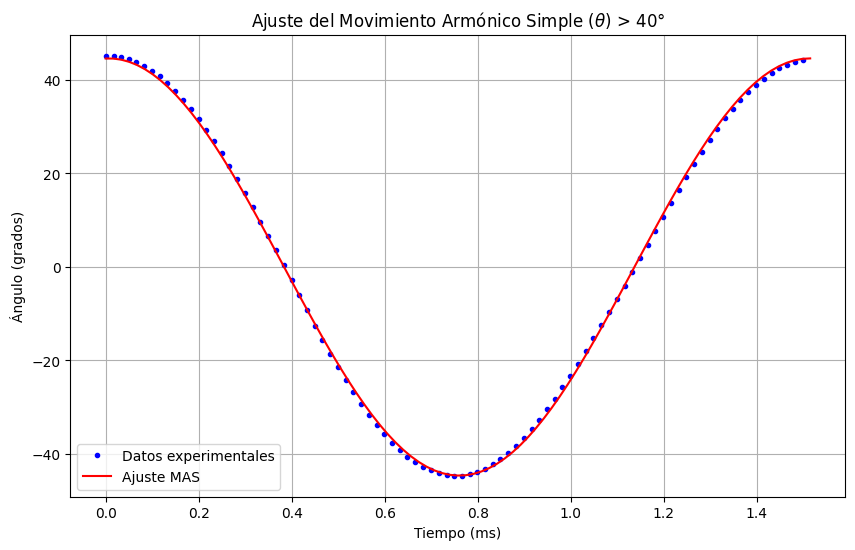

In [15]:
# Gráfica de ajuste MAS
plt.figure(figsize=(10, 6))
plt.plot(tiempo, angulo, 'b.', label='Datos experimentales')
plt.plot(t_eval, ecuacion(t_eval, *popt), 'r-', label='Ajuste MAS')
plt.title(r'Ajuste del Movimiento Armónico Simple $(\theta)$ > 40°')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Ángulo (grados)')
plt.grid(True)
plt.legend()
plt.show()

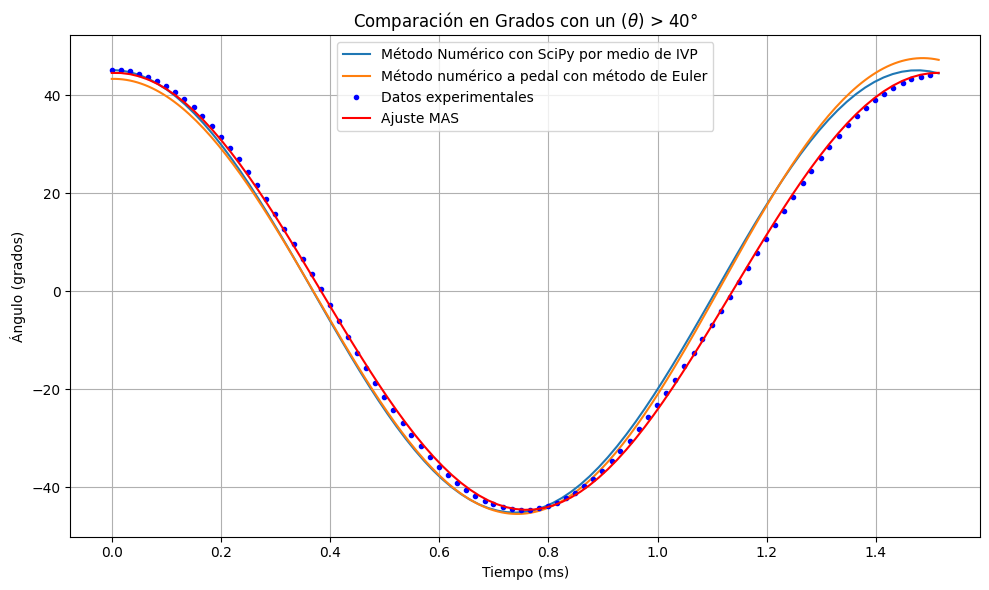

In [16]:
# Gráfica de comparación
plt.figure(figsize=(10, 6))
plt.plot(sol.t , sol_y_deg, label='Método Numérico con SciPy por medio de IVP')
plt.plot(t, u[:, 0]*55, label='Método numérico a pedal con método de Euler')
plt.plot(tiempo, angulo, 'b.', label='Datos experimentales')
plt.plot(t_eval, ecuacion(t_eval, *popt), 'r-', label='Ajuste MAS')
plt.title(r'Comparación en Grados con un ($\theta$) > 40°')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Ángulo (grados)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
